## Osciladores Anarmonicos
por: Miguel Sabogal, Hugo Torres, Mauricio Bandera y Juan Gallardo.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as op
import scipy as sc

## Runge kutta
El siguente es el runge kutta de orden 4 utilizado para resolver ambos modelos.

In [2]:
def rk4(f,x,t,h):
    "Runge kutta de orden 4, realiza la integracion en cierto intervalo de t ([t_i,t_f]) con un espaciado igual\
      al paso del runge kutta, h"
    h2=0.5*h
    for i in range(1,len(t)):
        k1= h*f(t[i-1],x[i-1])
        k2= h*f(t[i-1]+h2,x[i-1]+0.5*k1); k3= h*f(t[i-1]+h2, x[i-1]+0.5*k2); k4= h*f(t[i-1]+h,x[i-1]+k3)
        x[i]= x[i-1]+(k1+2*(k2+k3)+k4)/6 
    return x 

## Oscilador Anarmonico - Primer modelo - Tipo alpha
Cómo primer modelo, suponemos un potencial, el cual se comporta cómo un oscilador armónico para pequeños desplazamientos $"x"$, y también contiene una perturbación que introduce un término no lineal a la fuerza para valores grandes de $"x"$:
\begin{equation}
V(x)\simeq \frac{1}{2} kx^{2}(1-\frac{2}{3}\alpha x) \hspace{1.5cm} F_{k}(x)=-\frac{dV(x)}{dx}=-kx(1-\alpha x)=m \frac{d^{2}x}{dt^{2}}
\end{equation}


In [3]:
def OscAnar1(Integrador,Cnste_Elastica,Masa,Amplitud,Desfase,alpha,to,tf,h,Graficas=False):
    """Asignacion de parametros"""
    k= Cnste_Elastica ; m= Masa ; A= Amplitud ; phi= Desfase ; w= np.sqrt(k/m)
    
    #Condiciones iniciales 
    """Se establecen las condiciones iniciales del problema, donde xo=(x_0,v_0)""" 
    xo=np.array([A*np.cos(phi),-A*w*np.sin(phi)])
    
    """Se impone un condiconal, pues si la energia mecanica inicial del sistema supera o es igual 
       a la de la separatrix, el movieminto pasa de ser oscilatorio a translacional"""
    
    if alpha !=0 and 0.5*( m*xo[1]**2+(k*xo[0]**2 *(1-(2/3)*alpha*xo[0])) ) >= k/(6*alpha**2): 
        return 0.0, "Error pasó separatrix,No existe fuerza restaurativa, Movimiento traslacional"
    
    """En base a los parametros y al paso del runge kutta (h), se establece n que es el numero de particiones 
       del arreglo de los tiempos a evaluar, tambien se establece x, una matriz de ceros de dos columnas 
       (posicion,velocidad) y de la misma longitud (filas) que el arreglo de tiempos, donde la primera fila 
       de la matrix x corresponde a las condiciones iniciales """
    
    n=int((tf-to)/h) ; t=np.linspace(to,tf,n) ; x=np.zeros([len(t),2]) ; x[0]=xo
    
    #Función vectorial de derivadas (dx/dt, dv/dt)
    """Se define una funcion que representa la derivada del vector dinamico, la cual sera integrada por el 
    runge kutta"""
    def dYdt(t,y,w=w,alpha=alpha): return np.array([y[1],-w**2 *y[0]*(1-alpha*y[0])]) 
    
    #Funcion para encontrar el periodo 
    def periodo(z,t):
        """Ésta funcion toma las posiciones del oscilador en el tiempo, y encuentra el momento en el que 
           pasa por cero, multiplicando la posicion i con la i+1, pues su producto sera negativo cuando pase por
           cero. Luego realiza el promedio entre los tiempos para estas posiciones, aproximando al momento 
           exacto en que pasa por cero. Despues de encontrar todos los tiempos en los que pasa por cero, 
           determina el periodo, en la diferencia entre el tiempo i+2 y el i. para finalmente hallar el 
           promedio del periodo"""
        top=[] ;  periodos=[]
        for i in range(1,len(t)):
            if z[i,0]*z[i-1,0] < 0: to= 0.5*(t[i-1] + t[i]) ; top= np.hstack((top,to))    
             
        for i in range(len(top)-2): Tp= top[i+2]-top[i] ; periodos = np.hstack((periodos,Tp))
            
        if len(periodos) < 1: return 0.0, "No suficientes tiempo, para encontrar el periodo"  
        
        return periodos.mean(), periodos.std()
    
    """Se obtienen las posiciones y velocidades"""  
    Y=Integrador(dYdt,x,t,h)  
    """Se obtiene el periodo promedio y su desviacion estandar"""
    T=periodo(Y,t)
    
    # Energia Mecanica del sistema
    """A partir de las posiciones y velocidades encontradas, se determina la energia del sistema 
       {Energia cinetica-K,Energia pontencia elastica-V,Energia Mecanica-ET} en cada tiempo evaluado"""
    
    K= 0.5*m*(Y[:,1]**2)  ;  V= (0.5*k*(Y[:,0]**2 ) )* (1-(2/3)*alpha*Y[:,0])  ;  ET= K + V
    
    #Graficas-(x,v) vs t, (K,V,ET) vs t, V vs X.
    if Graficas != False:
        plt.plot(t,Y[:,0],t,Y[:,1]), plt.legend(("Posición","Velocidad")), plt.grid(),plt.xlabel("Tiempo")
        plt.title("Vector dinámico vs tiempo, Modelo 1"),plt.ylabel("Y (t)");plt.show() # grafica 1
    
        plt.plot(t,ET,"k--",t,K,t,V,),plt.legend(("E-total","K","V")), plt.grid(),plt.xlabel("Tiempo") 
        plt.title("Energías vs tiempo, Modelo 1"),plt.ylabel("Energía");plt.show() #grafica 2
    
        plt.plot(Y[:,0],V,label="V(x) vs x"),plt.xlim(-2*A,2*A), plt.legend(),plt.grid()
        plt.xlabel("x"); plt.title("Pozo de potencial, Modelo 1"),plt.ylabel("V(x)");plt.show() #grafica 3
        
    if alpha != 0: E_alpha= k/(6*alpha**2) 
    else: E_alpha="Movimiento armonico"
        
    return "Periodo = ",T,"Posiciones(t) = ",Y[:,0],"Velocidades(t) = ",Y[:,1],"Energia inicial = ",ET[0],\
                                "Energia para separatrix =",E_alpha

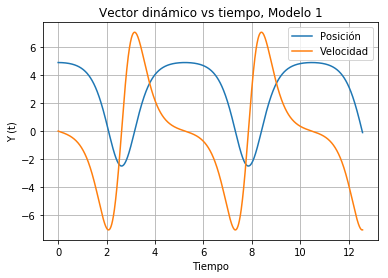

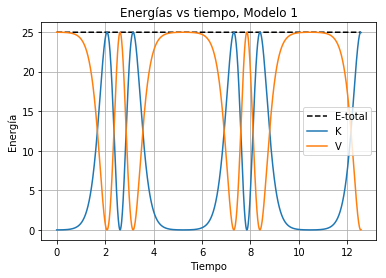

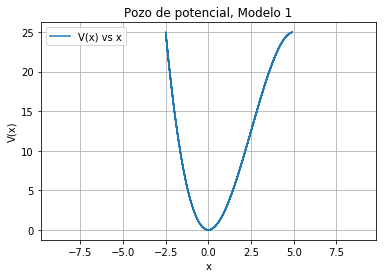

('Periodo = ',
 (5.236822176342508, 8.881784197001252e-16),
 'Posiciones(t) = ',
 array([ 4.9       ,  4.8999706 ,  4.89988238, ...,  0.03509472,
        -0.03557232, -0.10621776]),
 'Velocidades(t) = ',
 array([-0.00000000e+00, -5.88056448e-03, -1.17645163e-02, ...,
        -7.06636007e+00, -7.06634075e+00, -7.06202152e+00]),
 'Energia inicial = ',
 24.970400000000005,
 'Energia para separatrix =',
 24.999999999999996)

In [4]:
OscAnar1(rk4,6,1,4.9,0,0.2,0,4*np.pi,1e-2,Graficas=1)

### Variacion del periodo en funcion de la amplitud inicial
A continuacion se muestra la manera como se ve afectado el periodo al variar las condiciones iniciales del problema, en esta ocasion se tuvo en cuenta que el sistema parte del reposo, es decir $v_{0}=0$.

In [5]:
def Graficas_amplitudes_M1(to,tf,h,A1=0.5,A2=3,A3=4.9,phi=0,alpha=0.2):
    """Esta funcion determina el periodo de un oscilador para tres distintas amplitudes iniciales (tomado
       el set de parametros constante) y muestra como se ve afectado el movimiento"""
    # arreglo de tiempos y el numero de particiones
    n=int((tf-to)/h)  ;  t=np.linspace(to,tf,n)
    
    """Posiciones del oscilador despues de cierto tiempo tf, para tres condiciones iniciales distintas"""
    g1=OscAnar1(rk4,6,1,A1,phi,alpha,to,tf,h)   ;   g2=OscAnar1(rk4,6,1,A2,phi,alpha,to,tf,h)
    g3=OscAnar1(rk4,6,1,A3,phi,alpha,to,tf,h)
    
    #Graficas
    plt.plot(t,g1[3],linewidth=3)     ;   plt.plot(t,g2[3],"r-.",linewidth=2)
    plt.plot(t,g3[3],"k--",linewidth=1)
    plt.legend(("A1","A2","A3")),plt.grid(),plt.xlabel("Tiempo"),plt.ylabel("Posicion (t)")
    plt.title("Dependencia de la amplitud, alpha=0.2");plt.show()
    
    return "T1=",g1[1][0],"T2=",g2[1][0],"T3=",g3[1][0] #Periodo de los osciladores

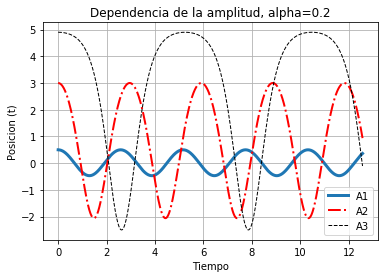

('T1=', 2.578358910914332, 'T2=', 2.952179231978935, 'T3=', 5.236822176342508)

In [6]:
Graficas_amplitudes_M1(0,4*np.pi,1e-2)

In [7]:
def P_Am_M1(Ao,Af,particiones,to=0,tf=4*np.pi,h=1e-2,alpha=0.2,k=6,m=1):
    """Esta funcion muestra garficamente la dependencia del periodo en funcion de la amplitud inicial, y
       realiza un fitting a la curva, utilizando la funcion curve_fit de la libreria scipy."""
    #Observación de la dependencia 
    Amplitudes=np.linspace(Ao,Af,particiones)   ;  Periodos=[]
    for i in range(len(Amplitudes)):
        A= Amplitudes[i] ; p=OscAnar1(rk4,k,m,A,0,alpha,to,tf,h)[1][0] ; Periodos= np.hstack((Periodos,p))
        
    #Ajuste o Fitting
    def f(x,a,b,c,d,e): return  d*np.exp(x**2/c) + e*np.exp(x/a) + b
    data=op.curve_fit(f,Amplitudes,Periodos) ; a,b,c,d,e=data[0] ; sigma=np.sqrt(np.diag(data[1]))
    
    chiq=sum( (Periodos-f(Amplitudes,a,b,c,d,e))**2 ) ; af=np.array([a,sigma[0]]) ; bf=np.array([b,sigma[1]])
    cf= np.array([c,sigma[2]]); df= np.array([d,sigma[3]])  ; ef= np.array([e,sigma[4]]) 
    
    
    #Grafica
    plt.plot(Amplitudes,Periodos,"k."), plt.plot(Amplitudes,f(Amplitudes,a,b,c,d,e))
    plt.grid(), plt.title("Periodo vs Amplitud, Modelo 1"),plt.xlabel("Amplitud (A)"),plt.ylabel("Periodo (T)")
    plt.legend(("T vs A","T(x) = d $e^{x^{2}/c}$+  n $e^{x/a}$ + b"));plt.savefig("TvsA-1-FT.eps");plt.show()  
    
    return "chiq=",chiq,"a=",af,"b=",bf ,"c=",cf,"d=",df,"e=",ef#Valores de los parametros del Fitting y sus std

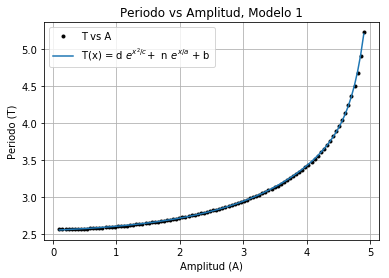

('chiq=',
 0.003371415472836265,
 'a=',
 array([1.38476856, 0.01126862]),
 'b=',
 array([2.50446488, 0.00253234]),
 'c=',
 array([1.82448626, 0.03287085]),
 'd=',
 array([1.84389766e-06, 4.50128449e-07]),
 'e=',
 array([0.05068699, 0.0012468 ]))

In [8]:
P_Am_M1(0.1,4.9,100,h=1e-3)

### Aproximación del modelo tipo alpha
Despues de realizar varios fitting (ajustes) variado el valor de $k,m$ y $\alpha$, se obtuvo una expresion analitica que aproxima el valor del periodo en funcion de la amplitud inicial.
$$T(A; T_{o},\alpha)\approx(k_{1} e^{A^{2}/k_{2}} + k_{3} e^{A/k_{4}} + k_{5} )T_{o} $$ 

In [9]:
def Aprox_Modelo_1(alpha,k,m,A):
    """Aproximacion de la forma como depende el periodo en funcion de la amplitud inical"""
    
    to=(2*np.pi)/(np.sqrt(k/m)) #Periodo "natural", si el oscilador fuera armonico
    
    a1=1.303e-13;b1= 9.645;                     k1=a1*np.exp(b1*alpha) 
    a2=14.838; b2=-10.485;                      k2=a2*np.exp(b2*alpha)
    a3=0.0232; b3=-3.827;                       k3=a3*np.exp(b3* alpha**2)  
    a4=3.277; b4= -4.335 ;                      k4=a4*np.exp(b4*alpha)
    a5=0.962; b5=0.0710 ;                       k5=a5*np.exp(b5*alpha)
        
    return (k1*np.exp((A**2)/k2) + k3*np.exp(A/k4) + k5)* to

In [10]:
alpha=0.2 ; k=6 ; m=5 ; A=3.9
Aprox_Modelo_1(alpha,k,m,A), OscAnar1(rk4,k,m,A,0,alpha,0,4*np.pi,1e-2)[1][0]

(7.535777920505509, 7.504776713515698)

## Oscilador Anarmonico - Segundo modelo - Tipo P
Para el segundo modelo de un oscilador no lineal, asumimos que el potencial del resorte es proporcional a cierta potencia $"p"$ arbitraria del desplazamiento $"x"$ desde el equilibrio:
\begin{equation}
V(x)=\frac{1}{p}kx^{p} \hspace{1.5cm} F_{k}(x)=-\frac{dV(x)}{dx}=-kx^{p-1}
\end{equation}

In [11]:
def OscAnar2(Integrador,Cnste_Elastica,Masa,Amplitud,Desfase,Power,to,tf,h,Graficas=False):
    """Asignacion de parametros"""
    k= Cnste_Elastica; m= Masa; A= Amplitud; phi= Desfase; p= Power; w= np.sqrt(k/m)
    
    #Condiciones iniciales 
    """Se establecen las condiciones iniciales del problema, donde xo=(x_0,v_0)""" 
    xo=np.array([A*np.cos(phi),-A*w*np.sin(phi)])
    
    """En base a los parametros y al paso del runge kutta (h), se establece n que es el numero de particiones 
       del arreglo de los tiempos a evaluar, tambien se establece x, una matriz de ceros de dos columnas 
       (posicion,velocidad) y de la misma longitud (filas) que el arreglo de tiempos, donde la primera fila 
       de la matrix x corresponde a las condiciones iniciales """
    n=int((tf-to)/h); t=np.linspace(to,tf,n); x=np.zeros([len(t),2]); x[0]=xo
    
    #Función vectorial (derivadas, dx/dt, dv/dt)
    """Se define una funcion que representa la derivada del vector dinamico, la cual sera integrada por el 
    runge kutta"""
    def f1(t,y,w=w,p=p): return np.array([y[1],-w**2 *y[0]**(p-1)])
    
    #Funcion para encontrar el periodo 
    def periodo(z,t):
        """Ésta funcion toma las posiciones del oscilador en el tiempo, y encuentra el momento en el que 
           pasa por cero, multiplicando la posicion i con la i+1, pues su producto sera negativo cuando pase por
           cero. Luego realiza el promedio entre los tiempos para estas posiciones, aproximando al momento 
           exacto en que pasa por cero. Despues de encontrar todos los tiempos en los que pasa por cero, 
           determina el periodo, en la diferencia entre el tiempo i+2 y el i. para finalmente hallar el 
           promedio del periodo"""
        top=[] ;  periodos=[]
        for i in range(1,len(t)):
            if z[i,0]*z[i-1,0] < 0: to= 0.5*(t[i-1] + t[i]) ; top= np.hstack((top,to))    
             
        for i in range(len(top)-2): Tp= top[i+2]-top[i] ; periodos = np.hstack((periodos,Tp))
            
        if len(periodos) < 1: return 0.0, "No suficientes tiempo, para encontrar el periodo"  
        
        return periodos.mean(), periodos.std()
    
    """Se obtienen las posiciones y velocidades"""  
    z=Integrador(f1,x,t,h)  #posiciones y velocidades   
    """Se obtiene el periodo promedio y su desviacion estandar"""
    T=periodo(z,t)
    
    # Energia Mecanica del sistema
    """A partir de las posiciones y velocidades encontradas, se determina la energia del sistema 
       {Energia cinetica-K,Energia pontencia elastica-V,Energia Mecanica-ET} en cada tiempo evaluado"""
    K= 0.5*m*(z[:,1]**2)  ;  V= (1/p)*k*(z[:,0])**(p)  ;  ET= K + V
    
    #Graficas-(x,v) vs t, (K,V,ET) vs t, V vs X.
    if Graficas != False:
        
        plt.plot(t,z[:,0],t,z[:,1]), plt.legend(("Posición","Velocidad")), plt.grid(),plt.xlabel("Tiempo")
        plt.ylabel("Y (t)"),plt.title("Vector dinámico vs tiempo, Modelo 2");plt.show() # grafica 1
    
        plt.plot(t,ET,"k--",t,K,t,V),plt.legend(("E-total","K","V")), plt.grid(),plt.xlabel("Tiempo") 
        plt.ylabel("Energía"),plt.title("Energías vs tiempo, Modelo 2");plt.show() #grafica 2
    
        plt.plot(z[:,0],V,label="V(x) vs x"),plt.xlim(-2*A,2*A), plt.legend(),plt.grid()
        plt.xlabel("x"),plt.title("Pozo de potencial, Modelo 2");plt.show() #grafica 3
    
    return "Periodo = ",T,"Posiciones(t) = ",z[:,0],"Velocidades(t) = ",z[:,1] 

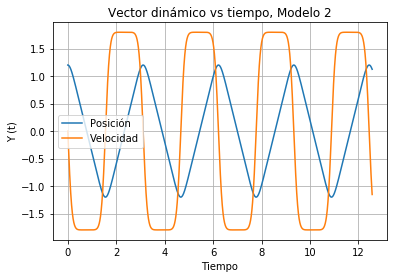

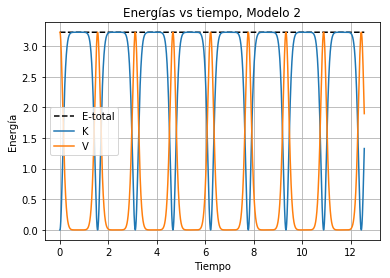

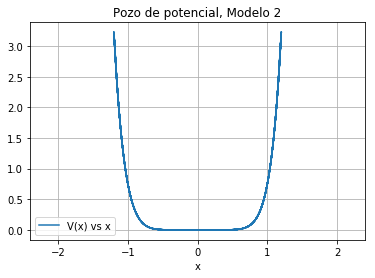

('Periodo = ',
 (3.110672614473682, 0.0004714559425020663),
 'Posiciones(t) = ',
 array([1.2       , 1.19999463, 1.1999785 , ..., 1.12532131, 1.12417942,
        1.12303072]),
 'Velocidades(t) = ',
 array([-0.        , -0.01074943, -0.02149819, ..., -1.13847401,
        -1.14530551, -1.15208848]))

In [12]:
OscAnar2(rk4,6,2,1.2,0,8,0,4*np.pi,1e-3,Graficas=True) 

In [13]:
def Graficas_amplitudes_M2(to,tf,h,A1=0.9,A2=1.1,A3=1.8,p=8):
    """Esta funcion determina el periodo de un oscilador para tres distintas amplitudes iniciales (tomado
       el set de parametros constante) y muestra como se ve afectado el movimiento"""
    
    #arreglo de tiempos y el numero de particiones
    n=int((tf-to)/h)  ; t=np.linspace(to,tf,n)
    
    """Posiciones del oscilador despues de cierto tiempo tf, para tres condiciones iniciales distintas"""
    g1=OscAnar2(rk4,6,1,A1,0,p,to,tf,h)   ;  g2=OscAnar2(rk4,6,1,A2,0,p,to,tf,h)
    g3=OscAnar2(rk4,6,1,A3,0,p,to,tf,h)
    
    #graficas
    plt.plot(t,g1[3],linewidth=3)  ; plt.plot(t,g2[3],"r-.",linewidth=2)
    plt.plot(t,g3[3],"k--",linewidth=1)
    plt.legend(("A1","A2","A3")) , plt.grid() , plt.xlabel("Tiempo") , plt.ylabel("Posicion (t)")
    plt.title("Dependencia de la amplitud, p=8");plt.show()
    
    return "T1, T2, T3 =",g1[1][0],g2[1][0],g3[1][0]

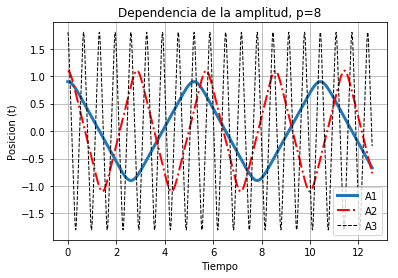

('T1, T2, T3 =', 5.213568644063221, 2.8555971743413875, 0.6516927017610042)

In [14]:
Graficas_amplitudes_M2(0,4*np.pi,1e-3)

In [15]:
def P_Am_M2(Ao,Af,particiones,to=0,tf=9*np.pi,h=1e-3,p=6,k=6,m=1):
    """Esta funcion muestra garficamente la dependencia del periodo en funcion de la amplitud inicial, y
       realiza un fitting a la curva, utilizando la funcion curve_fit de la libreria scipy."""
        
    #Observación de la dependencia 
    Amplitudes=np.linspace(Ao,Af,particiones)   ;    Periodos=[]
    for i in range(len(Amplitudes)):
        A= Amplitudes[i] ;  po=OscAnar2(rk4,k,m,A,0,p,to,tf,h)[1][0] ; Periodos= np.hstack((Periodos,po))
        
    #Ajuste o Fitting
    def f(x,a,b): return a/(x**b) 
    data=op.curve_fit(f,Amplitudes,Periodos) ; a,b=data[0] ; sigma=np.sqrt(np.diag(data[1]))
    
    chiq=sum( (Periodos-f(Amplitudes,a,b))**2 ) ; af=np.array([a,sigma[0]]) ; bf=np.array([b,sigma[1]]) 
    
    #grafica
    plt.plot(Amplitudes,Periodos,"k."),plt.plot(Amplitudes,f(Amplitudes,a,b))
    plt.grid(), plt.title("Periodo vs Amplitud, Modelo 2"),plt.xlabel("Amplitud (A)"),plt.ylabel("Periodo (T)")
    plt.legend(("T vs A","T(x) = a $x^{-b}$ "))  ;plt.show()

    return "a=",af,"b=",bf,"chiq=",chiq

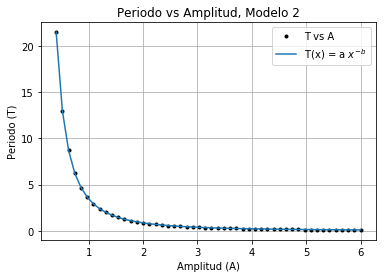

('a=',
 array([3.43478465e+00, 9.16832159e-06]),
 'b=',
 array([2.00002721e+00, 3.43696065e-06]),
 'chiq=',
 4.679216417797495e-08)

In [16]:
P_Am_M2(0.4,6,50)

### Aproximación del modelo tipo P
Despues de realizar varios fitting (ajustes) variado el valor de $k,m$ y $p$, se obtuvo una expresion analitica que aproxima el valor del periodo en funcion de la amplitud inicial.
$$T(A; T_{o},p)\approx(k_{1}^{n} A^{-n})T_{o}$$ 

In [17]:
def Aprox_Modelo_2(p,k,m,A):
    """Aproximacion de la forma como depende el periodo en funcion de la amplitud inical"""
    n=(p-2)/2 ; to=(2*np.pi)/(np.sqrt(k/m)) #Periodo "natural", si el oscilador fuera armonico
    
    a1= 1.196; b1= -0.0162
    return (a1*np.exp(b1*n))**n *to* A**(-n)

In [18]:
p=6;k=8; m=5; A=3
Aprox_Modelo_2(p,k,m,A),OscAnar2(rk4,k,m,A,0,p,0,4*np.pi,1e-3)[1][0] 

(0.7399416002399188, 0.7390806115409017)